In [4]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import skimage.io as iosk
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as trans
from skimage import exposure, util
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from skimage import img_as_ubyte
from skimage.transform import rescale, resize, downscale_local_mean
import time
import glob
from PIL import Image, ImageOps
import tensorflow as tf
import timeit
import zipfile
import random
import io
import os
from skimage import img_as_ubyte
import random



In [2]:

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

261
1/1 [==============================] - 1s 623ms/step


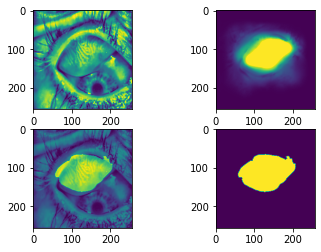

In [8]:
model_loaded = []
name = 'unet_membrane_meibogland_300.hdf5'
model_loaded = unet(name)

target_size = (256,256)
flag_multi_class = False

test_path_m = "/home/umcg/Desktop/Proyecto_Meibo/Meibos_465/Imgs/"
i = random.randrange(465)
print(i)
imgr = iosk.imread(os.path.join(test_path_m,"lid_%d.BMP"%i),as_gray = True)
imgr = trans.resize(imgr,target_size)
imgr = exposure.equalize_adapthist(np.matrix.squeeze(imgr), clip_limit=0.04)#CLAHE
imgr = np.reshape(imgr,imgr.shape+(1,)) if (not flag_multi_class) else img
imgr = np.reshape(imgr,(1,)+imgr.shape)

res = model_loaded.predict(imgr)
ress  = np.matrix.squeeze(res)
norm = (ress - np.min(ress)) / (np.max(ress) - np.min(ress))
norm[norm>.5]=1
norm[norm<.51]=0

plt.subplot(2,2,1),plt.imshow(np.matrix.squeeze(imgr))
plt.subplot(2,2,2),plt.imshow(ress)
plt.subplot(2,2,3),plt.imshow(norm+np.matrix.squeeze(imgr))
plt.subplot(2,2,4),plt.imshow(norm)
plt.show()

